In [1]:
!pip install keras
!pip install tensorflow
!pip install --upgrade protobuf


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 516.2 MB 5.1 kB/s  eta 0:00:01��██▌     | 426.9 MB 53.7 MB/s eta 0:00:02��██▊     | 430.3 MB 53.7 MB/s eta 0:00:02
     |████████████████████████████████| 3.0 MB 65.2 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 69.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 455 kB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 1.3 MB/s  eta 0:00:01
     |████████████████████████████████| 57 kB 1.4 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 65.0 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 64.7 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 1.3 MB/s  eta 0:00:01
     |██████████████████████

  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.7.1
    Uninstalling protobuf-3.7.1:
      Successfully uninstalled protobuf-3.7.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: protobuf in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (3.12.2)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/chainer_p36/bin/python -m pip install --upgrade pip' command.


In [49]:
import sagemaker
import boto3
from sagemaker import get_execution_role
import json
import psycopg2
import datetime
import os 
import time
from boto3.dynamodb.conditions import Key, Attr
import numpy as np
import pandas as pd
import sagemaker
import boto3
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
region = boto3.Session().region_name
from IPython.display import display
from time import strftime, gmtime
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
session = sagemaker.Session()
role = get_execution_role()

# This is the client we will use to interact with SageMaker AutoPilot
sm = boto3.Session().client(service_name='sagemaker',region_name=region)

In [51]:
region = boto3.Session().region_name

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'sagemaker/autopilot-dm'

role = get_execution_role()

sm = boto3.Session().client(service_name='sagemaker',region_name='region')


# Fetching data From the Source

In [52]:
nova_data=pd.read_csv('./nova_real_time_data.csv')

# EDA - Exploratory Data Analysis
In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.


In [53]:
options=[ 'Door Open'] 
sensor_one=nova_data[(nova_data['IMEI'] == 868446031859974) & 
          nova_data['messageType'].isin(options)]

In [54]:
sensor_one['timeStamp']=pd.to_datetime(sensor_one['timeStamp'])
sensor_one['date'] = sensor_one['timeStamp'].dt.date
sensor_one.head()

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,IMEI,batteryVoltage,currentMode,dataType,heading,humidity,latitude,longitude,messageType,satelliteNumber,speed,temperature,timeStamp,weather,date
294,868446031859974,4.045,0,GPS data,240,NaN,41.00484,-73.84871,Door Open,4,0.92km/h,NaN,2020-07-06 00:16:27,NaN,2020-07-06
295,868446031859974,3.975,0,GPS data,0,NaN,41.00496,-73.84837,Door Open,5,0.00km/h,NaN,2020-07-10 02:06:33,NaN,2020-07-10
296,868446031859974,4.055,0,GPS data,220,NaN,41.00484,-73.84833,Door Open,5,0.00km/h,NaN,2020-07-04 13:44:58,NaN,2020-07-04
297,868446031859974,4.037,0,GPS data,0,NaN,41.00483,-73.84818,Door Open,4,0.00km/h,NaN,2020-07-06 14:22:08,NaN,2020-07-06
298,868446031859974,3.889,0,GPS data,0,51%,41.00486,-73.84888,Door Open,4,0.00km/h,27.25°C,2020-07-15 20:30:53,Clouds,2020-07-15


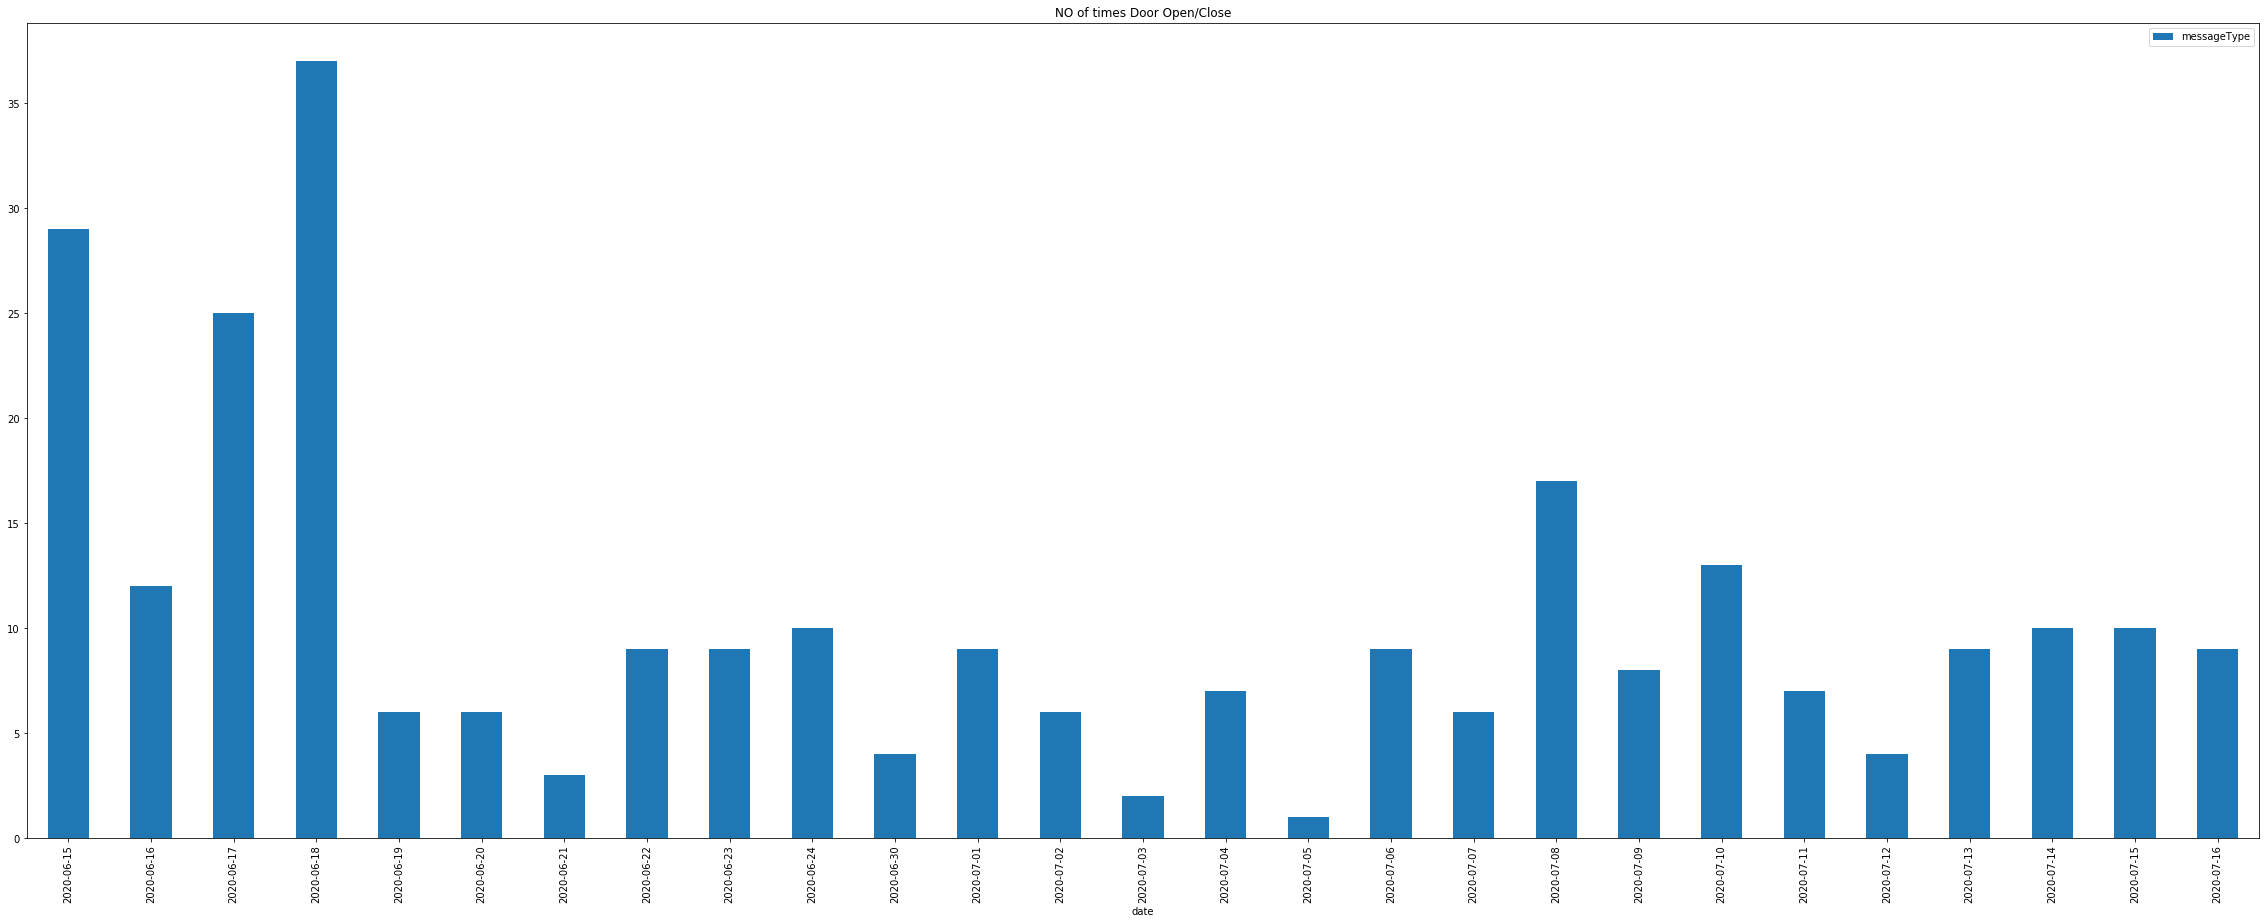

In [55]:
dataframe = sensor_one.groupby(["date"])['messageType'].count()
dataframe.plot(kind="bar",figsize=(40, 15),legend=True,
                         title="NO of times Door Open/Close")

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


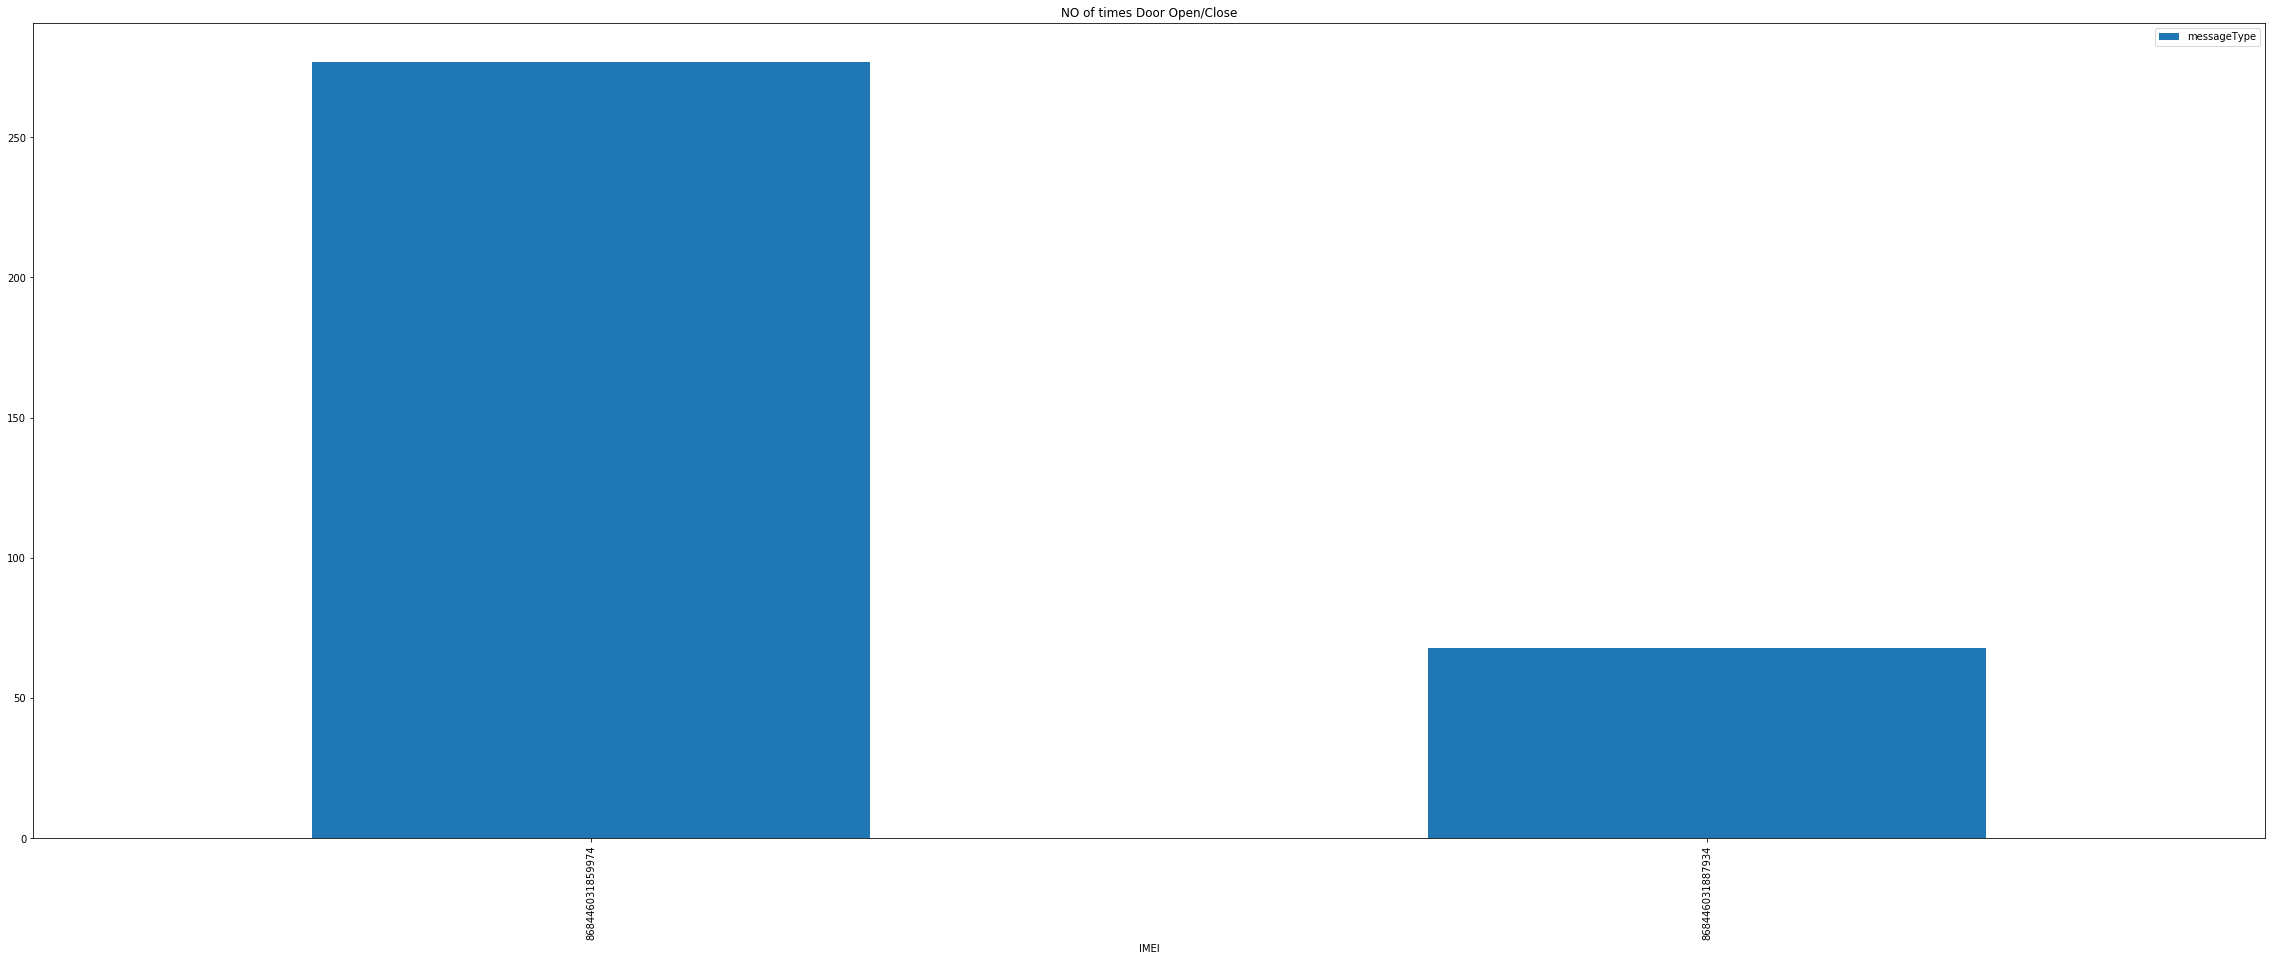

In [86]:
options=[ 'Door Open'] 
sensors=nova_data[
  nova_data['messageType'].isin(options)]
sensors['timeStamp']=pd.to_datetime(sensors['timeStamp'])
sensors['date'] = sensors['timeStamp'].dt.date

dataframe_ = sensors.groupby(["IMEI"])['messageType'].count()
dataframe_.plot(kind="bar",figsize=(40, 15),legend=True,
                         title="NO of times Door Open/Close")

# Feature Engineering

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. 

In [56]:
#dataframe=pd.set_index(dataframe.date)
dataframe=dataframe.reset_index(name='count')
dataframe.head()

,date,count
0,2020-06-15,29
1,2020-06-16,12
2,2020-06-17,25
3,2020-06-18,37
4,2020-06-19,6


In [57]:
dataframe=dataframe.set_index('date')

In [58]:
dataframe.head()

,count
date,
2020-06-15,29
2020-06-16,12
2020-06-17,25
2020-06-18,37
2020-06-19,6


# Lets Start Preparation For AI

# Train/TEST Split 

In [59]:
train_size = int(len(dataframe) * 0.67)
test_size = len(dataframe) - train_size
train, test = dataframe[0:train_size], dataframe[train_size:len(dataframe)]
print(len(train), len(test))

18 9


# Normalization 

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

#### X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#### X_scaled = X_std * (max - min) + min

In [60]:
# normalize the dataset
scaler = MinMaxScaler()
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)


# MODEL TRAINING

In [61]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
# create and fit the LSTM network
n_input=17
n_feature=1
generator=TimeseriesGenerator(train, train,length=n_input,  batch_size=6)

model = Sequential()
model.add(LSTM(200,activation='relu' ,input_shape=(n_input, n_feature)))
model.add(Dropout(0.16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(generator,epochs=200)


Epoch 1/200
1/1 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 6.1534e-04
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 1.1978e-04
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 11/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 12/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 13/200
1/1 [==============================] - 0

1/1 [==============================] - 0s 2ms/step - loss: 7.6788e-06
Epoch 198/200
1/1 [==============================] - 0s 3ms/step - loss: 5.1057e-07
Epoch 199/200
1/1 [==============================] - 0s 1ms/step - loss: 1.2807e-05
Epoch 200/200
1/1 [==============================] - 0s 1ms/step - loss: 7.3223e-05


In [62]:
predict_list=[]
batch= train[-n_input:].reshape((1,n_input,n_feature))

for i in range(n_input):
    predict_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[predict_list[i]]],axis=1)

In [63]:
df_predict=pd.DataFrame(scaler.inverse_transform(predict_list),index=dataframe[-n_input:].index,columns=['Predictions'])

In [64]:
df_test=pd.concat([dataframe,df_predict],axis=1)

In [65]:
df_test.head()

,count,Predictions
2020-06-15,29,NaN
2020-06-16,12,NaN
2020-06-17,25,NaN
2020-06-18,37,NaN
2020-06-19,6,NaN


In [66]:
df_test.tail()

,count,Predictions
2020-07-12,4,5.269170
2020-07-13,9,5.269438
2020-07-14,10,5.261537
2020-07-15,10,5.265236
2020-07-16,9,5.253719


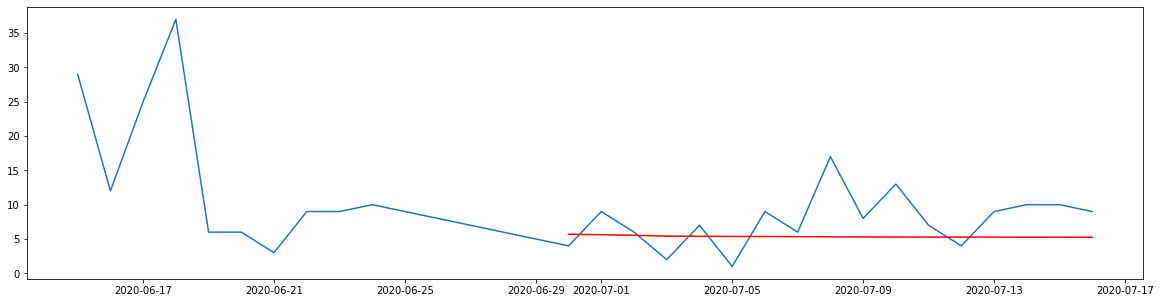

In [67]:
plt.figure(figsize=(20,5))
plt.plot(df_test.index,df_test['count'])
plt.plot(df_test.index,df_test['Predictions'],color='r')
plt.show()


# Train again (To reduce loss)

In [68]:
train=dataframe
scaler.fit(train)
train=scaler.transform(train)

n_input=17
n_feature=1


generator=TimeseriesGenerator(train, train,length=n_input,  batch_size=6)

model.fit_generator(generator,epochs=200)
predict_list=[]
batch= train[-n_input:].reshape((1,n_input,n_feature))

for i in range(n_input):
    predict_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[predict_list[i]]],axis=1)

Epoch 1/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0172
Epoch 2/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0120
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0088
Epoch 4/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0118
Epoch 5/200
2/2 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 7/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 8/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 9/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 10/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 11/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 12/200
2/2 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 13/200
2/2 [==============================] - 0s 10

# Predicting FUTURE

In [74]:
from pandas.tseries.offsets import DateOffset
add_dates= [dataframe.index[-1] + DateOffset(days=x) for x in range(0,18)]
future_dates =pd.DataFrame(index=add_dates[1:],columns=dataframe.columns)


In [75]:
future_dates.tail()

,count
2020-07-29,NaN
2020-07-30,NaN
2020-07-31,NaN
2020-08-01,NaN
2020-08-02,NaN


In [76]:
df_predict=pd.DataFrame(scaler.inverse_transform(predict_list),index=future_dates[-n_input:].index,columns=['Predictions'])
df_proj=pd.concat([dataframe,df_predict],axis=1)

In [77]:
df_proj.tail()

,count,Predictions
2020-07-29 00:00:00,NaN,7.928595
2020-07-30 00:00:00,NaN,9.149060
2020-07-31 00:00:00,NaN,8.996053
2020-08-01 00:00:00,NaN,8.880973
2020-08-02 00:00:00,NaN,8.867573


No handles with labels found to put in legend.


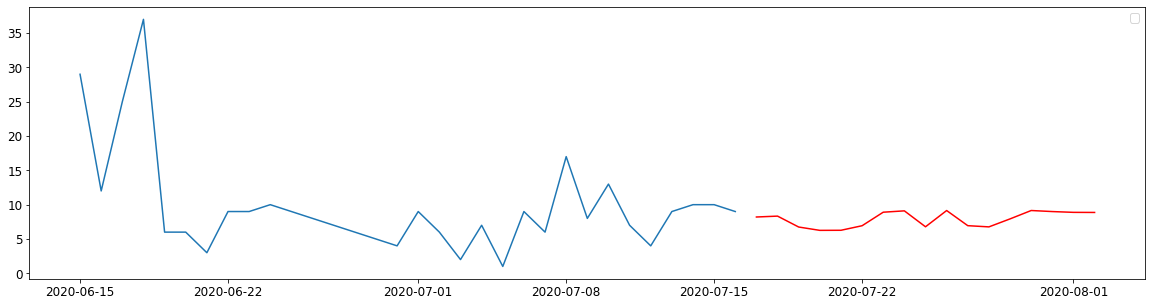

In [79]:
plt.figure(figsize=(20,5))
plt.plot(df_proj.index,df_proj['count'])
plt.plot(df_proj.index,df_proj['Predictions'],color='r')
plt.legend(loc='best',fontsize='large')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
